## **🔄 Cell 1 — Start Fresh**
Before diving into training, we first clean up any leftover files from previous runs.  
This ensures we’re starting with a clean environment and avoids unexpected conflicts.  

- Remove old model checkpoints and training history logs  
- Clear cached Python bytecode (`__pycache__`)  
- Free up any leftover GPU memory  

Finally, we print a confirmation that we’re ready to continue with a clean slate.  


In [ ]:
# Wipe artifacts from any previous run in this session
!rm -f /content/unet_abdomenus_best.pt /content/unet_training_history.*
!rm -rf /content/__pycache__

# If you want to force a fresh dataset download too, uncomment the next line:
# !rm -f ~/.medsegbench/abdomenus_256.npz

import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Clean slate.")


Clean slate.


## **🔄 Step 2: Restarting the Kernel to Apply Changes**

In this step, we are restarting the Python kernel to make sure recent updates (like library or environment changes) take effect.

- 📦 **Import modules**:  
  - `os` → to interact with the operating system.  
  - `sys` → for system-related functions (though not directly used here).  
  - `time` → to add a short pause before restarting.  

- 💬 **Notify user**: We print a message so it’s clear the kernel will restart.  

- ⏳ **Add delay**: A `1-second` pause (`time.sleep(1)`) gives time to read the message.  

- 💥 **Restart kernel**: `os.kill(os.getpid(), 9)` forcefully stops the current process.  
  👉 In Jupyter/Colab, this triggers an automatic kernel restart.


In [ ]:
import os, sys, time
print("Restarting kernel to finalize NumPy/ORT changes...")
time.sleep(1)
os.kill(os.getpid(), 9)


Restarting kernel to finalize NumPy/ORT changes...


## **🔌 Step 3: Disconnecting the Colab Runtime**

In this step, we are manually disconnecting the Colab runtime session.

- 🔽 **Import runtime tools**:  
  From `google.colab`, we import the `runtime` module, which allows us to control and manage the notebook runtime.  

- ❌ **End session**:  
  Calling `runtime.unassign()` disconnects the current runtime, effectively shutting down the backend session.  
  👉 This is useful if you want to stop using GPU/TPU resources or fully reset the environment.


In [ ]:
from google.colab import runtime
runtime.unassign()

## **⚙️ Step 4: Colab and System Setup**

In this step, we prepare the environment by installing dependencies and importing essential libraries.

- 📥 **Install packages**:  
  We install and upgrade key packages needed for medical image segmentation and deep learning:  
  - `medsegbench` → a benchmark toolkit for medical image segmentation.  
  - `torch` and `torchvision` → PyTorch deep learning framework and vision utilities.  
  - `matplotlib` → for visualizations.  
  - `pillow` → for image handling.  
  - `scipy` → for scientific computations.  

- 📚 **Import libraries**:  
  We bring in Python standard libraries (`os`, `sys`, `random`, etc.), NumPy, PyTorch modules, and visualization tools.  

- 🖥 **Check system info**:  
  - Print Python version.  
  - Print Torch version.  
  - Check CUDA availability (GPU support).  

- ⚡ **Device setup**:  
  We define `DEVICE` as `"cuda"` if a GPU is available, otherwise fallback to `"cpu"`.  
  This ensures all computations run on the fastest hardware available.


In [ ]:
# Colab/system setup
!pip -q install --upgrade medsegbench torch torchvision matplotlib pillow scipy

import os, sys, random, math, hashlib, subprocess, pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.cuda.is_available())
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.2 MB/s eta 0:00:00
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch : 2.8.0+cu126
CUDA  : True


'cuda'

## **🎲 Step 5: Ensuring Reproducibility**

In this step, we set fixed seeds so that our experiments give consistent results every time we run them.  
Reproducibility is especially important in deep learning projects like segmentation, where randomness can affect results.

- 🔑 **Define seed value**:  
  We use `SEED = 42`, a commonly used constant for reproducibility.  

- 🐍 **Set Python random seed**:  
  Ensures consistent behavior in Python’s built-in random operations.  

- 🔢 **Set NumPy seed**:  
  Makes NumPy-generated random numbers repeatable.  

- 🔥 **Set PyTorch seeds**:  
  - `torch.manual_seed(SEED)` for CPU.  
  - `torch.cuda.manual_seed(SEED)` and `torch.cuda.manual_seed_all(SEED)` for GPU computations.  

- ⚙️ **Deterministic CUDA behavior**:  
  - `torch.backends.cudnn.deterministic = True` → forces deterministic results.  
  - `torch.backends.cudnn.benchmark = False` → prevents non-deterministic optimizations.  

✅ Finally, we print a message confirming reproducibility setup.


In [ ]:
import random
import numpy as np
import torch

# Fixed seed for reproducibility
SEED = 42

# Python random seed
random.seed(SEED)

# Numpy random seed
np.random.seed(SEED)

# Torch CPU seed
torch.manual_seed(SEED)

# Torch GPU seed (if using CUDA)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior in CUDA (important for segmentation)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Reproducibility set with seed = {SEED}")


Reproducibility set with seed = 42


## **📥 Step 6: Downloading and Verifying the AbdomenUSMSBench Dataset**

In this step, we fetch the **AbdomenUSMSBench (256px)** dataset from Zenodo and place it in the MedSegBench cache directory.  
We also verify the file integrity using an MD5 checksum to ensure safe and correct usage.

- 📂 **Set up dataset directory**:  
  - Define `SIZE = 256` for the image resolution.  
  - Create a cache directory (`~/.medsegbench`) to store the dataset.  
  - Update the environment variable `MEDSEGBENCH_DIR` so MedSegBench knows where to look.  

- 🔗 **Dataset source details**:  
  - `target_name` → expected dataset filename (`abdomenus_256.npz`).  
  - `url` → direct download link from Zenodo.  
  - `expected_md5` → official checksum to confirm file integrity.  

- 🧮 **MD5 checksum function**:  
  A helper `md5sum(path)` computes the hash of the downloaded file for verification.  

- ⬇️ **Download logic**:  
  - If the file is missing → attempt download using `curl`.  
  - If `curl` fails → fallback to `wget`.  
  - If already present → skip download.  

- ✅ **Verify file integrity**:  
  - Compare the computed MD5 hash with the expected one.  
  - If mismatched → raise an error and suggest redownload.  
  - If matched → confirm dataset is safe and ready for use.  

This ensures the dataset is both **downloaded and verified** before moving forward with segmentation experiments.


In [ ]:
# We’ll fetch AbdomenUSMSBench 256px from Zenodo and place it in MedSegBench’s cache.
SIZE = 256
root = os.path.expanduser("~/.medsegbench")
os.makedirs(root, exist_ok=True)
os.environ["MEDSEGBENCH_DIR"] = root  # ensure medsegbench reads this

target_name = f"abdomenus_{SIZE}.npz"
target_path = os.path.join(root, target_name)
url = "https://zenodo.org/records/13358372/files/abdomenus_256.npz?download=1"
expected_md5 = "c2eb21d1a93d857c472b01a72a210030"  # from authors’ note

def md5sum(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

if not os.path.exists(target_path):
    print(f"Downloading to {target_path} ...")
    try:
        subprocess.run(["curl", "-L", "-f", url, "-o", target_path], check=True)
    except subprocess.CalledProcessError:
        print("curl failed; trying wget...")
        subprocess.run(["wget", "-O", target_path, url], check=True)
else:
    print("File already present:", target_path)

got = md5sum(target_path)
print("MD5:", got)
if got != expected_md5:
    raise RuntimeError(
        f"MD5 mismatch for {target_name}. Expected {expected_md5}, got {got}.\n"
        "Delete the file and rerun this cell to redownload."
    )
print("✅ Download + MD5 OK at", target_path)


MD5: c2eb21d1a93d857c472b01a72a210030
✅ Download + MD5 OK at /root/.medsegbench/abdomenus_256.npz


## **📊 Step 7: Loading the AbdomenUSMSBench Dataset**

Now that the dataset is downloaded and verified, we load it into MedSegBench for training, validation, and testing.

- 📥 **Load dataset splits**:  
  Using `AbdomenUSMSBench` we create three subsets:  
  - `train_ds_raw` → training data.  
  - `val_ds_raw` → validation data.  
  - `test_ds_raw` → test data.  

- ⚙️ **Configuration**:  
  - `split` → specifies which portion of the dataset to load (`train`, `val`, `test`).  
  - `size=SIZE` → ensures images are resized to `256 × 256`.  
  - `download=False` → prevents re-downloading since we already fetched the dataset.  

- 🖨 **Check dataset sizes**:  
  We print the number of samples in each split, confirming everything loaded correctly.

👉 With this step, the dataset is fully ready for preprocessing and model training.


In [ ]:
from medsegbench import AbdomenUSMSBench

# Use the file we just placed (download=False avoids re-fetch)
train_ds_raw = AbdomenUSMSBench(split="train", size=SIZE, download=False)
val_ds_raw   = AbdomenUSMSBench(split="val",   size=SIZE, download=False)
test_ds_raw  = AbdomenUSMSBench(split="test",  size=SIZE, download=False)

print(f"Train: {len(train_ds_raw)} | Val: {len(val_ds_raw)} | Test: {len(test_ds_raw)} (size={SIZE})")


Train: 569 | Val: 64 | Test: 293 (size=256)


## **🖼️ Step 8: Utility Functions for Visualizing Images and Masks**

Before training, it’s important to visually inspect the dataset.  
Here we define helper functions to display images alongside their segmentation masks, with clear legends.

- 🖌 **Image conversion (`to_numpy_image`)**:  
  - Converts input images (PIL, Torch tensor, or NumPy) into a standard NumPy format.  
  - Ensures correct channel order (H×W×C).  
  - Normalizes values to `[0, 1]` for display.  

- 🎭 **Mask conversion (`to_numpy_mask`)**:  
  - Converts masks into integer arrays.  
  - Each integer represents a class label for segmentation.  

- 🌈 **Colormap builder (`build_discrete_cmap`)**:  
  - Creates a discrete color map where each class gets a unique color.  
  - Background is shown as light gray for clarity.  
  - Uses `tab20` palette for variety.  

- 👁 **Visualization function (`show_image_mask_with_legend`)**:  
  - Accepts a `(image, mask)` pair or a dictionary with `{"image", "mask"}`.  
  - Displays:
    1. **Original image**.  
    2. **Image with segmentation mask overlay**.  
  - Adds a **color legend (class IDs)** so each region is easily identified.  
  - Titles include present labels in the sample for quick reference.  

👉 With these utilities, we can **quickly verify** if the dataset samples and their corresponding masks are aligned and correct.


In [ ]:
# Utilities to display raw samples with a clear legend
def to_numpy_image(x):
    if "PIL" in str(type(x)):
        x = np.array(x)
    elif isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
        if x.ndim == 3 and x.shape[0] in (1,3):
            x = np.transpose(x, (1,2,0))
    x = x.astype(np.float32)
    if x.ndim == 2:
        x = np.stack([x, x, x], axis=-1)
    if x.max() > 1.5:
        x /= 255.0
    return x

def to_numpy_mask(m):
    if "PIL" in str(type(m)):
        m = np.array(m)
    elif isinstance(m, torch.Tensor):
        m = m.detach().cpu().numpy()
    return m.astype(np.int64)

from matplotlib.colors import ListedColormap, BoundaryNorm
def build_discrete_cmap(max_label_id):
    base = plt.get_cmap("tab20").colors
    colors = []
    for i in range(max_label_id + 1):
        if i == 0: colors.append((0.85,0.85,0.85))  # background
        else:      colors.append(base[(i-1) % len(base)])
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_label_id+1.5, 1), cmap.N)
    return cmap, norm

def show_image_mask_with_legend(sample, title=None, alpha=0.4):
    # sample may be (img, mask) tuple or dict {'image','mask'}
    if isinstance(sample, (tuple, list)):
        image, mask = sample[0], sample[1]
    else:
        image, mask = sample["image"], sample["mask"]

    img = to_numpy_image(image)
    msk = to_numpy_mask(mask)
    present = np.unique(msk)
    max_id = int(present.max()) if present.size > 0 else 0
    cmap, norm = build_discrete_cmap(max_id)

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")

    axes[1].imshow(img);
    overlay = np.ma.masked_where(msk == 0, msk)
    axes[1].imshow(overlay, cmap=cmap, norm=norm, alpha=alpha, interpolation="nearest")
    axes[1].set_title("Overlay (mask)"); axes[1].axis("off")

    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=norm),
        ax=axes[1], fraction=0.046, pad=0.04,
        ticks=np.arange(0, max_id+1)
    )
    cbar.ax.set_yticklabels([f"Class {i}" for i in range(max_id+1)])
    if not title: title = "Sample with class legend"
    fig.suptitle(f"{title}\nPresent labels: {list(present)}", y=1.03)
    plt.tight_layout()
    plt.show()


## **👀 Step 9: Visualizing Sample Images and Masks**

Now we put our visualization utilities into action by displaying one example from each dataset split.

- 🏋️ **Training sample** → shows how input images and their segmentation masks look in the training set.  
- 🧪 **Validation sample** → helps check if preprocessing and labeling are consistent in the validation set.  
- 📊 **Test sample** → ensures the test set is correctly structured and ready for final evaluation.  

Each visualization includes:  
- Left: the **original ultrasound image**.  
- Right: the **image with segmentation mask overlay**, along with a **legend** for class IDs.  

👉 This step provides a quick sanity check to confirm dataset integrity before we move on to model training.


Train sample:


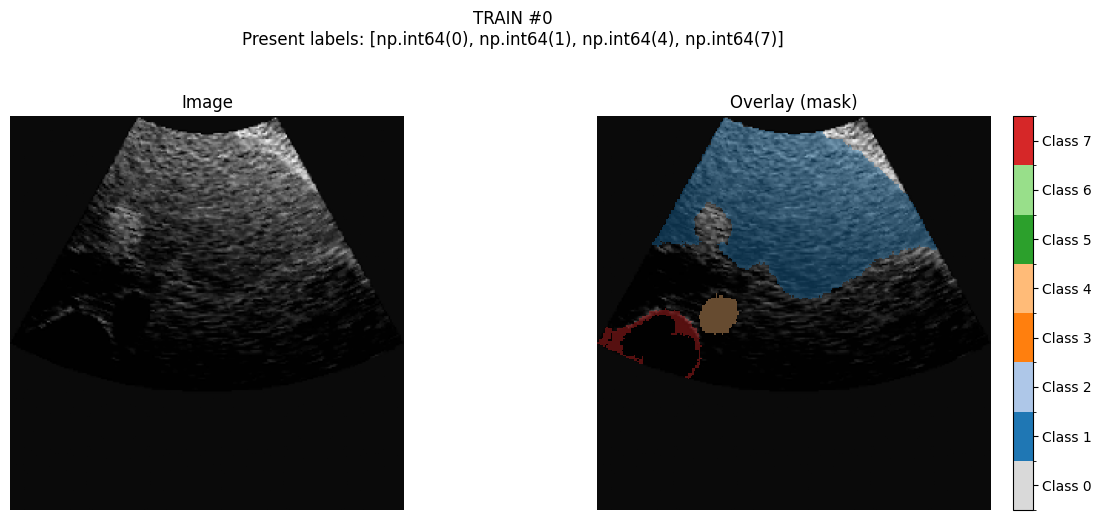

Val sample  :


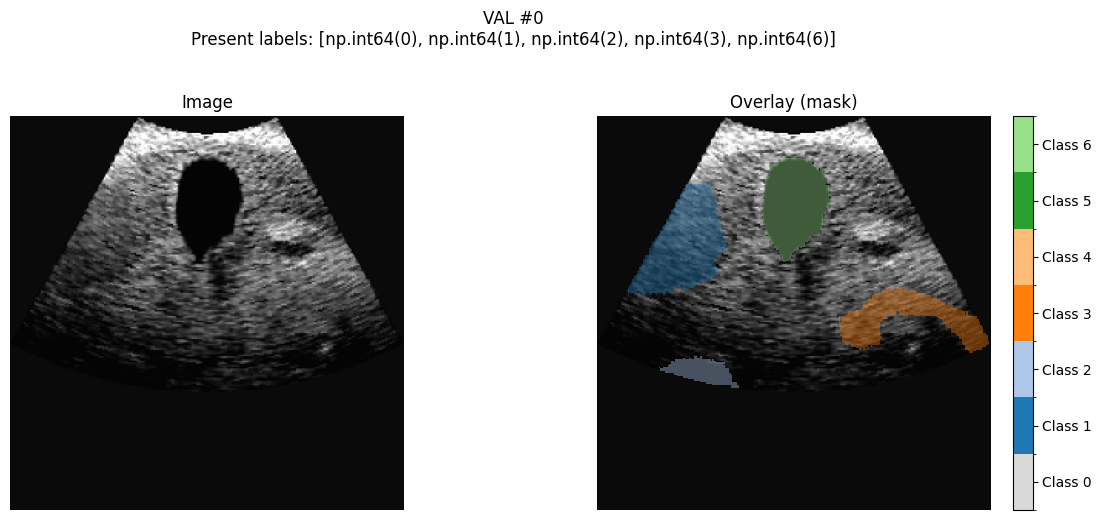

Test sample :


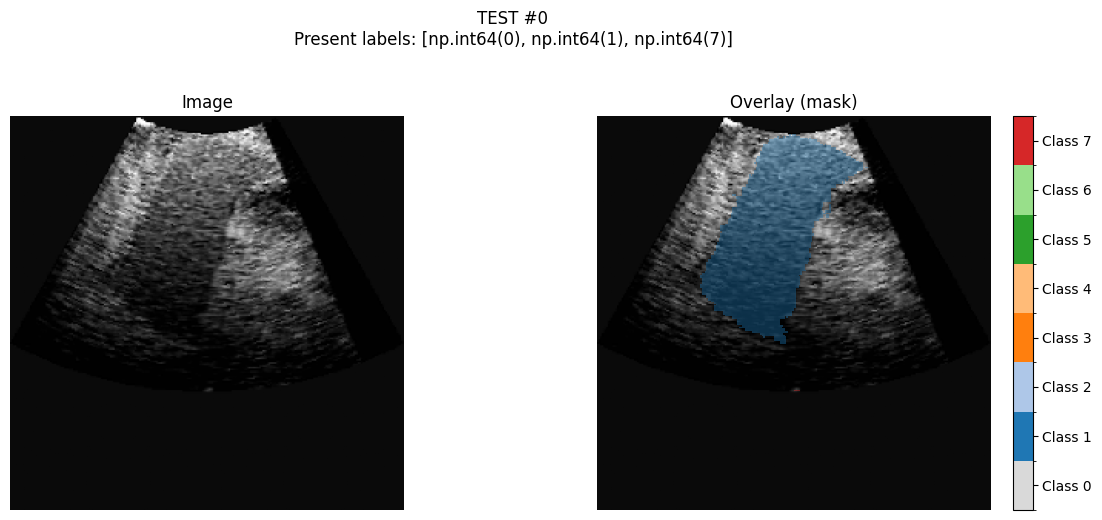

In [ ]:
print("Train sample:"); show_image_mask_with_legend(train_ds_raw[0], "TRAIN #0")
print("Val sample  :"); show_image_mask_with_legend(val_ds_raw[0],   "VAL #0")
print("Test sample :"); show_image_mask_with_legend(test_ds_raw[0],  "TEST #0")


## **🏷️ Step 10: Discovering Dataset Labels**

In segmentation tasks, each pixel in the mask corresponds to a **class ID**.  
This step scans the dataset to identify which labels are present across training, validation, and test splits.

- 🔍 **Label discovery function (`discover_labels`)**:  
  - Loops through a subset of dataset samples (`n` examples).  
  - Extracts the segmentation mask.  
  - Collects all **unique class IDs** found in those masks.  
  - Returns the sorted list of discovered labels.  

- 📊 **Apply to splits**:  
  - `labels_train` → unique labels in the training set.  
  - `labels_val` → unique labels in the validation set.  
  - `labels_test` → unique labels in the test set.  

- 🧮 **Infer number of classes**:  
  - Combines labels across all splits.  
  - Computes the maximum label ID + 1 → `NUM_CLASSES`.  
  - This value is essential for defining the output layer of the segmentation model.  

👉 This step ensures we know exactly how many categories the model must learn to predict.


In [ ]:
def discover_labels(ds, n=200):
    seen = set()
    up_to = min(n, len(ds))
    for i in range(up_to):
        sample = ds[i]
        mask = sample[1] if isinstance(sample, (tuple,list)) else sample["mask"]
        seen.update(np.unique(to_numpy_mask(mask)).tolist())
    return sorted(seen)

labels_train = discover_labels(train_ds_raw, n=500)
labels_val   = discover_labels(val_ds_raw,   n=500)
labels_test  = discover_labels(test_ds_raw,  n=500)

print("Labels (train):", labels_train)
print("Labels (val)  :", labels_val)
print("Labels (test) :", labels_test)

NUM_CLASSES = int(max(labels_train + labels_val + labels_test)) + 1
print("→ NUM_CLASSES inferred:", NUM_CLASSES)


Labels (train): [0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels (val)  : [0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels (test) : [0, 1, 2, 3, 4, 5, 6, 7, 8]
→ NUM_CLASSES inferred: 9


In [ ]:
"""
class TorchSegDataset(Dataset):
    """
    Wraps a MedSegBench split and returns:
      image: float tensor [C,H,W] in [0,1]
      mask : long tensor  [H,W] with class IDs
    """
    def __init__(self, base_ds, train=True):
        self.base = base_ds
        self.train = train

    def __len__(self):
        return len(self.base)

    def _apply_transforms(self, img, msk):
        # Basic paired augmentations for training
        if self.train:
            if random.random() < 0.5:
                img = TF.hflip(img); msk = TF.hflip(msk)
            if random.random() < 0.3:
                img = TF.vflip(img); msk = TF.vflip(msk)
            # (Optional) small random affine w/ nearest on masks can be added carefully

        # To tensor
        img_t = TF.to_tensor(img)                  # [C,H,W], float32 in [0,1]
        msk_np = np.array(msk, dtype=np.int64)     # [H,W], ints
        msk_t = torch.from_numpy(msk_np)           # LongTensor

        return img_t, msk_t

    def __getitem__(self, idx):
        sample = self.base[idx]
        if isinstance(sample, (tuple, list)):
            img, msk = sample[0], sample[1]
        else:
            img, msk = sample["image"], sample["mask"]
        return self._apply_transforms(img, msk)

# Build wrapped datasets
train_ds = TorchSegDataset(train_ds_raw, train=True)
val_ds   = TorchSegDataset(val_ds_raw,   train=False)
test_ds  = TorchSegDataset(test_ds_raw,  train=False)

# DataLoaders
BATCH_SIZE = 8  # safe for Colab free GPU at 256px; adjust if OOM
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)""" """


(72, 8, 37)

## **📦 Step 11: Wrapping the Dataset into PyTorch `Dataset` and `DataLoader`**

To train a segmentation model in PyTorch, we need a dataset class that outputs image–mask pairs in a tensor format.  
This step builds a custom wrapper around the AbdomenUSMSBench dataset and prepares DataLoaders for training.

---

### 📝 Custom Dataset Class: `TorchSegDataset`
- **Purpose**: Converts the raw dataset into a PyTorch-friendly format.  
- **Outputs**:  
  - `image`: Float tensor `[3, H, W]` scaled to `[0,1]`.  
  - `mask`: Long tensor `[H, W]` with integer class IDs.  

#### Key Features:
- 🔄 **Conversion**: Handles inputs whether they are PIL, NumPy, or Torch tensors.  
- 📐 **Shape correction**: Ensures images always have a channel dimension.  
- 🎲 **Data augmentation (train only)**:  
  - 50% chance → horizontal flip.  
  - 30% chance → vertical flip.  
- 🎨 **Normalization**:  
  - If pixel values are in `0–255`, they are scaled to `0–1`.  
  - Grayscale images are expanded into 3 channels for consistency.  

---

### 🚚 DataLoader Setup
- **Datasets**:  
  - `train_ds` → with augmentation enabled.  
  - `val_ds`, `test_ds` → without augmentation.  

- **Batching and workers**:  
  - `BATCH_SIZE = 8` (images per batch).  
  - `num_workers` set to 2 if using GPU, else 0.  
  - `pin_memory=True` if CUDA is available for faster data transfer.  

- **DataLoaders**:  
  - `train_loader` → shuffled for training.  
  - `val_loader` & `test_loader` → not shuffled, for consistent evaluation.  

👉 This step ensures that training, validation, and testing can be done efficiently with mini-batches and proper preprocessing.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch, random

class TorchSegDataset(Dataset):
    """
    Returns:
      image: float tensor [3,H,W] in [0,1]
      mask : long  tensor [H,W]   with class IDs
    """
    def __init__(self, base_ds, train=True):
        self.base = base_ds
        self.train = train

    def __len__(self):
        return len(self.base)

    def _to_np(self, x):
        # handle PIL / numpy / tensor
        if isinstance(x, np.ndarray): return x
        if isinstance(x, torch.Tensor): return x.detach().cpu().numpy()
        return np.array(x)  # PIL -> np

    def __getitem__(self, idx):
        sample = self.base[idx]
        img = sample[0] if isinstance(sample, (tuple, list)) else sample["image"]
        msk = sample[1] if isinstance(sample, (tuple, list)) else sample["mask"]

        img = self._to_np(img)  # HxW or HxWxC
        msk = self._to_np(msk)  # HxW (int labels)

        # Ensure HWC for image
        if img.ndim == 2:
            img = img[..., None]

        # ----- NumPy-safe paired augments -----
        if self.train:
            if random.random() < 0.5:
                img = np.flip(img, axis=1).copy()
                msk = np.flip(msk, axis=1).copy()
            if random.random() < 0.3:
                img = np.flip(img, axis=0).copy()
                msk = np.flip(msk, axis=0).copy()

        # ----- To tensors -----
        img = img.astype(np.float32)
        if img.max() > 1.5:  # scale 0..255 -> 0..1
            img = img / 255.0

        # make 3 channels (U/S is often grayscale)
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)

        img_t = torch.from_numpy(img.transpose(2, 0, 1))           # [C,H,W]
        msk_t = torch.from_numpy(msk.astype(np.int64))              # [H,W]
        return img_t, msk_t

# Build wrapped datasets
train_ds = TorchSegDataset(train_ds_raw, train=True)
val_ds   = TorchSegDataset(val_ds_raw,   train=False)
test_ds  = TorchSegDataset(test_ds_raw,  train=False)

# DataLoaders (avoid pin_memory on CPU-only)
BATCH_SIZE = 8
pin_mem = torch.cuda.is_available()
num_workers = 2 if pin_mem else 0

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_mem)


## **🏗️ Step 12: Building the U-Net Model**

U-Net is a popular architecture for **image segmentation**, especially in medical imaging.  
Here we define a modular U-Net in PyTorch, ready for training on our dataset.

---

### 🧱 Model Components

1. **DoubleConv**  
   - Two consecutive convolution layers (`3x3`) + BatchNorm + ReLU.  
   - Used repeatedly in both encoder and decoder blocks.

2. **Down (Encoder block)**  
   - Max pooling (`2x2`) followed by `DoubleConv`.  
   - Reduces spatial dimensions while increasing feature channels.

3. **Up (Decoder block)**  
   - Upsamples the feature map (bilinear or transposed convolution).  
   - Concatenates with the corresponding encoder feature map (skip connection).  
   - Applies `DoubleConv` to refine features.

4. **OutConv**  
   - `1x1` convolution to produce the final `n_classes` output channels.

---

### 🔄 Full U-Net (`UNet` class)

- **Encoder path**: `inc → down1 → down2 → down3 → down4`.  
- **Decoder path**: `up1 → up2 → up3 → up4`.  
- **Skip connections**: Connect encoder and decoder features for better localization.  
- **Output**: `logits` with shape `[batch_size, NUM_CLASSES, H, W]`.

---

### ⚡ Model Initialization

- `n_channels=3` → input has 3 channels (grayscale repeated).  
- `n_classes=NUM_CLASSES` → matches the number of segmentation labels discovered.  
- `bilinear=True` → uses bilinear upsampling.  
- `base_ch=64` → number of filters in the first layer (doubles in deeper layers).  
- `.to(DEVICE)` → moves model to GPU if available.  

- ✅ We also print the total number of parameters in **millions**, which gives a sense of model size.

This modular setup ensures flexibility for training, evaluation, and experimentation.


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)
        self.bilinear = bilinear

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True, base_ch=64):
        super().__init__()
        self.inc   = DoubleConv(n_channels, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.down3 = Down(base_ch*4, base_ch*8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_ch*8, base_ch*16 // factor)
        self.up1   = Up(base_ch*16, base_ch*8 // factor, bilinear)
        self.up2   = Up(base_ch*8,  base_ch*4 // factor, bilinear)
        self.up3   = Up(base_ch*4,  base_ch*2 // factor, bilinear)
        self.up4   = Up(base_ch*2,  base_ch, bilinear)
        self.outc  = OutConv(base_ch, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)
        return logits

model = UNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True, base_ch=64).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6  # params (M)


13.391881

## **🧮 Step 13: Defining Loss Functions, Metrics, and Optimizer**

Segmentation requires specialized losses and metrics to handle multi-class pixel-wise predictions.  
Here we set up **Soft Dice Loss**, evaluation metrics, and the optimizer.

---

### 🎯 Soft Dice Loss (`soft_dice_loss`)
- Measures overlap between predicted probabilities and ground-truth masks.  
- Works for **multi-class segmentation** (`logits` shape `[N,C,H,W]`).  
- Handles **ignore_index** to skip certain classes (like background) if needed.  
- Steps:  
  1. Convert targets to **one-hot encoding**.  
  2. Compute **intersection** and **cardinality** per class.  
  3. Dice per class → `(2*intersection + eps) / (cardinality + eps)`.  
  4. Return `1 - mean_dice` as loss.

---

### 📏 Metrics (`compute_metrics`)
- Computes **IoU** (Intersection over Union) and **Dice coefficient** for evaluation.  
- Converts logits to class predictions via `argmax`.  
- Ignores pixels marked by `ignore_index` if provided.  
- Loops through each class to compute:  
  - **IoU** = intersection / union  
  - **Dice** = `2 * intersection / (sum of predicted + sum of target)`  
- Returns **mean IoU** and **mean Dice** across classes.

---

### ⚡ Losses and Optimizer
- `ce_loss` → Standard Cross-Entropy Loss for multi-class segmentation.  
- `optimizer` → `AdamW` with learning rate `3e-4` and weight decay `1e-4`.  
- `scaler` → Automatic Mixed Precision (AMP) GradScaler for faster training on GPU.

---

### 🔹 Notes
- `IGNORE_INDEX = None` → all classes are considered.  
- Using **Soft Dice + Cross-Entropy** helps stabilize learning, especially for imbalanced segmentation datasets.


In [ ]:
def soft_dice_loss(logits, targets, num_classes, eps=1e-6, ignore_index=None):
    """
    Multi-class soft Dice on logits (N,C,H,W) vs targets (N,H,W).
    Ignores 'ignore_index' if provided.
    """
    # One-hot targets
    N, C, H, W = logits.shape
    if ignore_index is not None:
        mask_valid = (targets != ignore_index).float()
    else:
        mask_valid = torch.ones_like(targets, dtype=torch.float32, device=targets.device)

    probs = F.softmax(logits, dim=1)
    tgt_oh = F.one_hot(torch.clamp(targets, min=0), num_classes=num_classes)  # (N,H,W,C)
    tgt_oh = tgt_oh.permute(0,3,1,2).float()  # (N,C,H,W)

    # Apply valid mask (broadcast)
    probs = probs * mask_valid.unsqueeze(1)
    tgt_oh = tgt_oh * mask_valid.unsqueeze(1)

    dims = (0,2,3)
    intersection = torch.sum(probs * tgt_oh, dims)
    cardinality  = torch.sum(probs + tgt_oh, dims)
    dice_per_class = (2. * intersection + eps) / (cardinality + eps)

    if ignore_index is not None and ignore_index < num_classes:
        dice_per_class = dice_per_class[torch.arange(num_classes) != ignore_index]

    return 1.0 - dice_per_class.mean()

def compute_metrics(logits, targets, num_classes, ignore_index=None, eps=1e-6):
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)  # (N,H,W)
        valid = (targets != ignore_index) if ignore_index is not None else torch.ones_like(targets, dtype=torch.bool)
        ious = []
        dices = []
        for cls in range(num_classes):
            if ignore_index is not None and cls == ignore_index:
                continue
            pred_c = (preds == cls) & valid
            targ_c = (targets == cls) & valid
            inter = (pred_c & targ_c).sum().item()
            union = (pred_c | targ_c).sum().item()
            denom = (pred_c.sum() + targ_c.sum()).item()
            iou  = inter / (union + eps)
            dice = (2*inter) / (denom + eps)
            ious.append(iou)
            dices.append(dice)
        mean_iou  = float(np.mean(ious)) if ious else 0.0
        mean_dice = float(np.mean(dices)) if dices else 0.0
    return mean_iou, mean_dice

# Losses/optim
IGNORE_INDEX = None  # keep all classes; set to 0 to ignore background in Dice/metrics if desired
ce_loss = nn.CrossEntropyLoss()  # expects logits (N,C,H,W) and targets (N,H,W)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


/tmp/ipython-input-2162819106.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


## **⏱️ Step 14: Running One Epoch (Training or Validation)**

This function executes **one pass through the dataset** (one epoch) and calculates the loss and metrics.

---

### 🔹 Function: `run_epoch(loader, train_mode=True)`
- **Parameters**:  
  - `loader` → PyTorch DataLoader (train or validation).  
  - `train_mode` → `True` for training (updates weights), `False` for validation (just evaluation).

- **Setup**:  
  - Set the model to `train()` if training, else evaluation mode.  
  - Initialize accumulators for **loss**, **mean IoU**, and **mean Dice**.

---

### 🔄 Iterating over batches
1. Move inputs `xb` and targets `yb` to the selected `DEVICE` (CPU/GPU).  
2. If training → zero out gradients with `optimizer.zero_grad()`.  
3. Forward pass with **automatic mixed precision (AMP)** if GPU is available:  
   - Compute `logits = model(xb)`.  
   - Compute combined loss: **Cross-Entropy + Soft Dice**.  
4. Compute evaluation metrics: **mean IoU** and **mean Dice**.  
5. Accumulate batch losses and metrics.

---

### ⚡ Backpropagation (only if training)
- Scale the loss using AMP `scaler`.  
- Backward pass → `loss.backward()`.  
- Step the optimizer → `scaler.step(optimizer)` and `scaler.update()`.

---

### 📊 Return Values
- Average **loss**, **mean IoU**, and **mean Dice** over all batches.  

👉 This function works for both **training** (updates weights) and **validation** (evaluation only).


In [ ]:
import time

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    running_loss = 0.0
    running_miou = 0.0
    running_mdice = 0.0
    count = 0

    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(xb)
            loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)

        miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
        running_loss += loss.item()
        running_miou += miou
        running_mdice += mdice
        count += 1

        if train_mode:
            scaler.scale(loss).overload if hasattr(scaler, "overload") else None
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    return running_loss / count, running_miou / count, running_mdice / count


"""
EPOCHS = 10
best_val_dice = -1.0
best_path = "/content/unet_abdomenus_best.pt" """


"""
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_miou, tr_mdice = run_epoch(train_loader, train_mode=True)
    va_loss, va_miou, va_mdice = run_epoch(val_loader,   train_mode=False)

    dt = time.time() - t0
    print(f"[{epoch:02d}/{EPOCHS}] {dt:5.1f}s | "
          f"Train: loss={tr_loss:.4f} mIoU={tr_miou:.4f} mDice={tr_mdice:.4f} || "
          f"Val: loss={va_loss:.4f} mIoU={va_miou:.4f} mDice={va_mdice:.4f}")

    # save best by val Dice
    if va_mdice > best_val_dice:
        best_val_dice = va_mdice
        torch.save({"model": model.state_dict(),
                    "num_classes": NUM_CLASSES,
                    "size": SIZE}, best_path)
        print(f"  ↪︎ Saved best checkpoint (val mDice={best_val_dice:.4f}) -> {best_path}")"""


'\nfor epoch in range(1, EPOCHS+1):\n    t0 = time.time()\n    tr_loss, tr_miou, tr_mdice = run_epoch(train_loader, train_mode=True)\n    va_loss, va_miou, va_mdice = run_epoch(val_loader,   train_mode=False)\n\n    dt = time.time() - t0\n    print(f"[{epoch:02d}/{EPOCHS}] {dt:5.1f}s | "\n          f"Train: loss={tr_loss:.4f} mIoU={tr_miou:.4f} mDice={tr_mdice:.4f} || "\n          f"Val: loss={va_loss:.4f} mIoU={va_miou:.4f} mDice={va_mdice:.4f}")\n\n    # save best by val Dice\n    if va_mdice > best_val_dice:\n        best_val_dice = va_mdice\n        torch.save({"model": model.state_dict(),\n                    "num_classes": NUM_CLASSES,\n                    "size": SIZE}, best_path)\n        print(f"  ↪︎ Saved best checkpoint (val mDice={best_val_dice:.4f}) -> {best_path}")'

## **🚀 Step 15: Training Loop and Checkpointing**

This step runs the **full training process** for multiple epochs, evaluates on the validation set, and saves the best model.

---

### 🔹 Setup
- `history` → stores per-epoch metrics for **training and validation** (loss, mean IoU, mean Dice).  
- `EPOCHS = 100` → total number of epochs to train.  
- `best_val_dice` → tracks the best validation Dice score.  
- File paths:  
  - `best_path` → where the best model checkpoint is saved.  
  - `hist_path_npz` & `hist_path_json` → save training history for plotting later.

---

### 🔄 Epoch Loop
1. Record start time for timing the epoch.  
2. Run one epoch on the **training set** → get `train_loss`, `train_miou`, `train_mdice`.  
3. Run one epoch on the **validation set** → get `val_loss`, `val_miou`, `val_mdice`.  
4. Update `history` dictionary with metrics.  
5. Print **epoch summary** with time, training metrics, and validation metrics.  

---

### 💾 Checkpointing
- If the **validation mean Dice improves**, save the model checkpoint:  
  - Saves `state_dict`, `NUM_CLASSES`, and `SIZE` for reproducibility.  
- Ensures we always keep the **best-performing model** on the validation set.

---

### 📊 Saving Training History
- Saves in **two formats** for convenience:  
  1. `.npz` → fast NumPy load for plotting.  
  2. `.json` → readable format for analysis or logging.  

- ✅ Prints confirmation of saved history paths.

---

This step ensures the **model is trained, evaluated, and checkpointed**, while recording all metrics for later visualization and analysis.


In [ ]:
import time, json, numpy as np

# History containers (per-epoch)
history = {
    "epoch": [],
    "train_loss": [], "train_miou": [], "train_mdice": [],
    "val_loss":   [], "val_miou":   [], "val_mdice":   []
}

EPOCHS = 100
best_val_dice = -1.0
best_path = "/content/unet_abdomenus_best.pt"
hist_path_npz = "/content/unet_training_history.npz"
hist_path_json = "/content/unet_training_history.json"

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_miou, tr_mdice = run_epoch(train_loader, train_mode=True)
    va_loss, va_miou, va_mdice = run_epoch(val_loader,   train_mode=False)
    dt = time.time() - t0

    # log to history
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_miou"].append(tr_miou)
    history["train_mdice"].append(tr_mdice)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_mdice"].append(va_mdice)

    print(f"[{epoch:02d}/{EPOCHS}] {dt:5.1f}s | "
          f"Train: loss={tr_loss:.4f} mIoU={tr_miou:.4f} mDice={tr_mdice:.4f} || "
          f"Val: loss={va_loss:.4f} mIoU={va_miou:.4f} mDice={va_mdice:.4f}")

    # save best by val Dice
    if va_mdice > best_val_dice:
        best_val_dice = va_mdice
        torch.save({"model": model.state_dict(),
                    "num_classes": NUM_CLASSES,
                    "size": SIZE}, best_path)
        print(f"  ↪︎ Saved best checkpoint (val mDice={best_val_dice:.4f}) -> {best_path}")

# Save history for later plotting (two formats)
np.savez(hist_path_npz, **history)
with open(hist_path_json, "w") as f:
    json.dump(history, f, indent=2)

print(f"✅ Saved training history to:\n- {hist_path_npz}\n- {hist_path_json}")


/tmp/ipython-input-601309921.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


[01/100]  13.0s | Train: loss=1.6841 mIoU=0.1561 mDice=0.1791 || Val: loss=1.5448 mIoU=0.1493 mDice=0.1732
  ↪︎ Saved best checkpoint (val mDice=0.1732) -> /content/unet_abdomenus_best.pt
[02/100]  13.2s | Train: loss=1.4045 mIoU=0.1629 mDice=0.1847 || Val: loss=1.3285 mIoU=0.1612 mDice=0.1830
  ↪︎ Saved best checkpoint (val mDice=0.1830) -> /content/unet_abdomenus_best.pt
[03/100]  13.3s | Train: loss=1.2791 mIoU=0.1667 mDice=0.1891 || Val: loss=1.3139 mIoU=0.1729 mDice=0.2076
  ↪︎ Saved best checkpoint (val mDice=0.2076) -> /content/unet_abdomenus_best.pt
[04/100]  13.1s | Train: loss=1.1844 mIoU=0.2043 mDice=0.2424 || Val: loss=1.1594 mIoU=0.2202 mDice=0.2653
  ↪︎ Saved best checkpoint (val mDice=0.2653) -> /content/unet_abdomenus_best.pt
[05/100]  13.0s | Train: loss=1.1150 mIoU=0.2309 mDice=0.2764 || Val: loss=1.1700 mIoU=0.2211 mDice=0.2706
  ↪︎ Saved best checkpoint (val mDice=0.2706) -> /content/unet_abdomenus_best.pt
[06/100]  12.9s | Train: loss=1.0617 mIoU=0.2527 mDice=0.306

## **🏁 Step 16: Evaluating on the Test Set**

After training, we evaluate the **best saved model** on the unseen test set.

---

### 🔹 Load Best Checkpoint
- Load the saved model dictionary from `best_path`.  
- Restore model weights with `model.load_state_dict(ckpt["model"])`.  
- Switch the model to **evaluation mode** → disables dropout and batch norm updates.

---

### 🔄 Run Test Evaluation
- Call `run_epoch(test_loader, train_mode=False)`:  
  - Computes **loss**, **mean IoU**, and **mean Dice** for the test set.  
- `train_mode=False` ensures no gradients are computed.

---

### 📊 Print Results
- Displays final **test metrics**:  
  - `loss` → combined Cross-Entropy + Soft Dice.  
  - `mIoU` → mean Intersection-over-Union across classes.  
  - `mDice` → mean Dice coefficient across classes.  

✅ This gives a clear picture of how well the model generalizes to unseen data.


In [ ]:
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

test_loss, test_miou, test_mdice = run_epoch(test_loader, train_mode=False)
print(f"TEST: loss={test_loss:.4f} | mIoU={test_miou:.4f} | mDice={test_mdice:.4f}")


/tmp/ipython-input-601309921.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


TEST: loss=0.7915 | mIoU=0.4056 | mDice=0.4868


## **🔮 Step 17: Visualizing Model Predictions with Overlay**

Once the model is trained, it’s useful to **see how predictions compare to ground truth**.  
This function overlays predicted masks on the original images for qualitative inspection.

---

### 🔹 Function: `predict_overlay(ds, n=3, alpha=0.4)`
- **Parameters**:  
  - `ds` → dataset to visualize (train, val, or test).  
  - `n` → number of random samples to display.  
  - `alpha` → transparency for overlay.  

---

### 🔄 Workflow
1. Select `n` random indices from the dataset.  
2. For each sample:  
   - Retrieve image (`img_t`) and mask (`msk_t`).  
   - Compute prediction using the trained model: `pred = argmax(logits)`.  
3. Convert tensors to NumPy arrays for visualization.  
4. Determine **maximum class ID** to build a discrete colormap.  
5. Plot **three side-by-side panels**:  
   1. **Original Image**  
   2. **Ground Truth Mask Overlay**  
   3. **Predicted Mask Overlay**  

- Uses `build_discrete_cmap` to assign distinct colors for each class.  
- Mask overlays are semi-transparent (`alpha`) to keep the image visible.  

---

✅ This step provides an intuitive view of model performance, highlighting areas of correct and incorrect segmentation.


In [ ]:
def predict_overlay(ds, n=3, alpha=0.4):
    model.eval()
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    for i in idxs:
        img_t, msk_t = ds[i]
        with torch.no_grad():
            logits = model(img_t.unsqueeze(0).to(DEVICE))
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

        img_np = np.transpose(img_t.numpy(), (1,2,0))  # [H,W,C]
        msk_np = msk_t.numpy()

        max_id = int(max(msk_np.max(), pred.max()))
        cmap, norm = build_discrete_cmap(max_id)

        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        axes[0].imshow(img_np); axes[0].set_title(f"Image (idx={i})"); axes[0].axis("off")

        axes[1].imshow(img_np)
        axes[1].imshow(np.ma.masked_where(msk_np == 0, msk_np), cmap=cmap, norm=norm, alpha=alpha)
        axes[1].set_title("Ground Truth"); axes[1].axis("off")

        axes[2].imshow(img_np)
        axes[2].imshow(np.ma.masked_where(pred == 0, pred), cmap=cmap, norm=norm, alpha=alpha)
        axes[2].set_title("Prediction"); axes[2].axis("off")

        plt.tight_layout()
        plt.show()


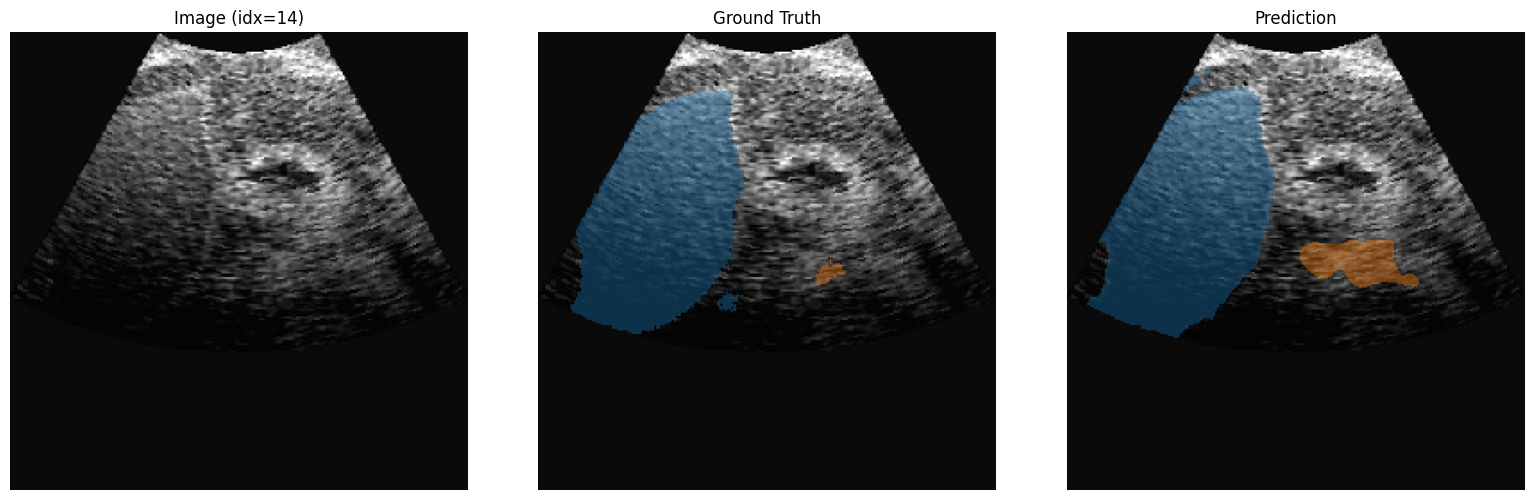

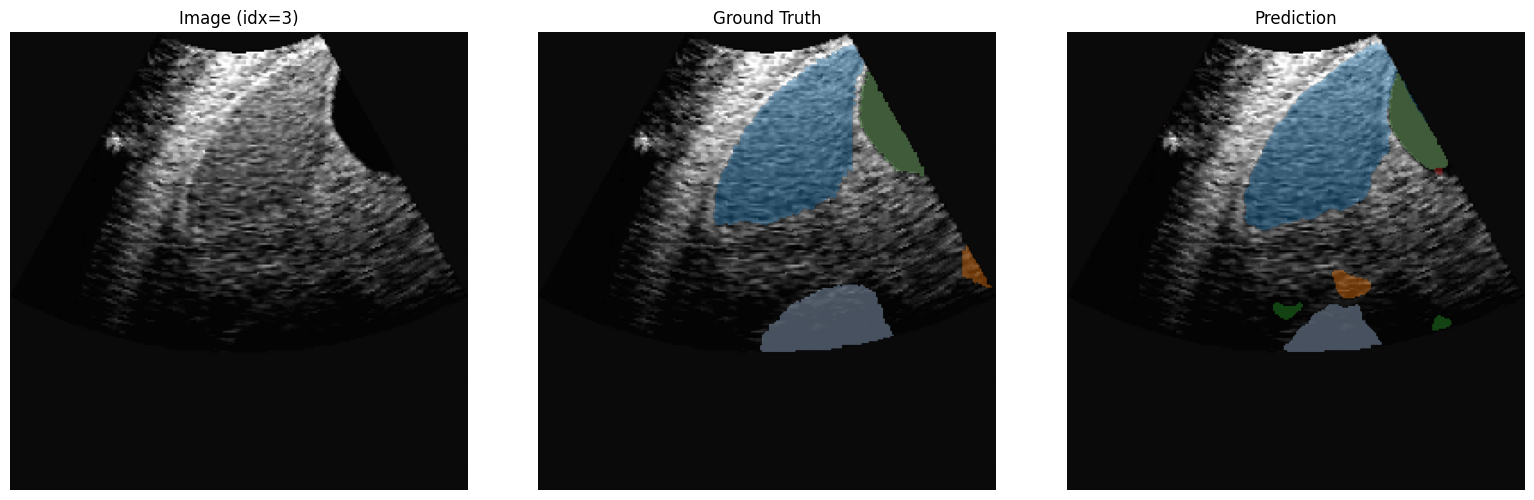

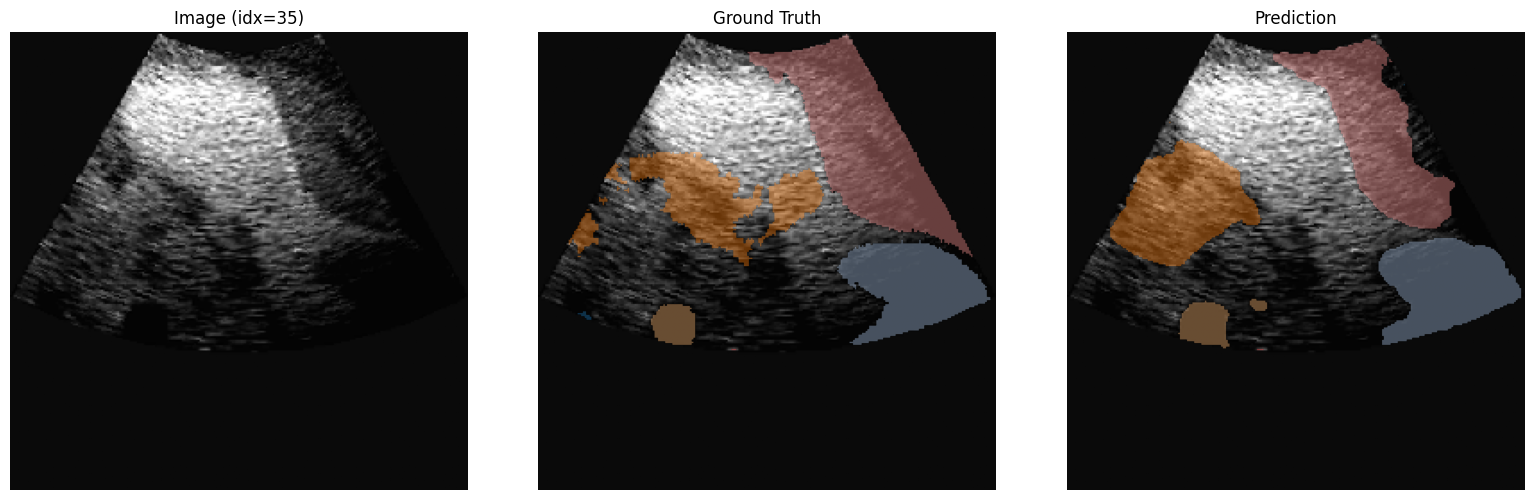

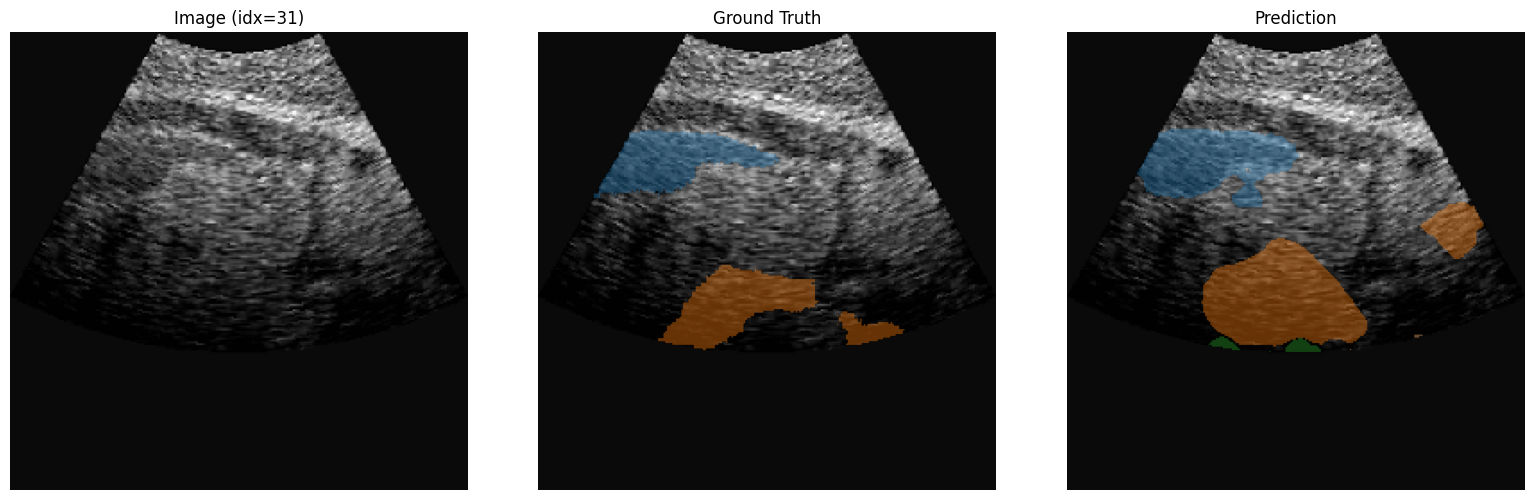

In [ ]:
# Show some predictions from the validation set (faster) or test set
predict_overlay(val_ds, n=4)

## **📈 Step 18: Plotting Training Metrics**

Visualizing training history helps to **understand model convergence** and detect overfitting or underfitting.

---

### 🔹 Load Training History
- Checks if `history` is already in memory.  
- If not, tries to load from disk:  
  - `/content/unet_training_history.npz` → NumPy binary.  
  - `/content/unet_training_history.json` → human-readable JSON.  
- Raises an error if no history is found.

---

### 🔹 Function: `plot_metric`
- **Parameters**:  
  - `epochs` → list of epoch numbers.  
  - `train_vals` → training metric values.  
  - `val_vals` → validation metric values.  
  - `title` → plot title.  
  - `ylabel` → y-axis label.  
  - `save_path` → optional path to save the figure.  
- Plots **train vs. validation curves** with grid and legend.  
- Saves figure if `save_path` is provided.

---

### 🔄 Plotting Example
- Plots **Loss over Epochs**:  
  - X-axis → epochs  
  - Y-axis → loss  
  - Shows training vs. validation curves.  
- Similar plots can be generated for **mIoU** and **mDice**.

---

✅ This visualization step provides **insight into training progress** and helps evaluate model performance over time.


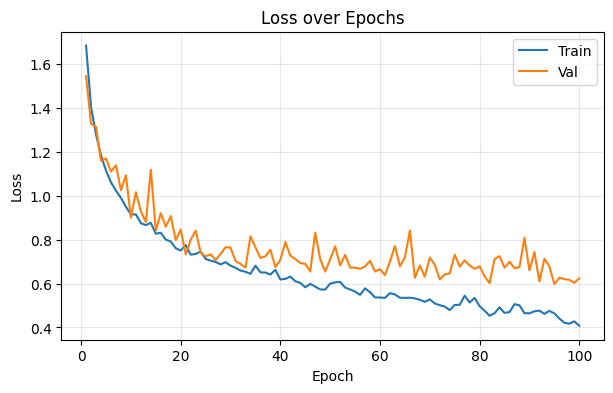

Saved plots to /content/plot_loss.png, /content/plot_mIoU.png, /content/plot_mDice.png


In [ ]:
import os, json, numpy as np
import matplotlib.pyplot as plt

# ---- Load history (from memory or disk) ----
if 'history' not in globals():
    hist = None
    if os.path.exists("/content/unet_training_history.npz"):
        data = np.load("/content/unet_training_history.npz", allow_pickle=True)
        hist = {k: data[k].tolist() for k in data.files}
    elif os.path.exists("/content/unet_training_history.json"):
        with open("/content/unet_training_history.json", "r") as f:
            hist = json.load(f)
    if hist is None:
        raise RuntimeError("No training history found in memory or at /content.")
    history = hist  # make available like in-memory case

epochs = history["epoch"]

def plot_metric(epochs, train_vals, val_vals, title, ylabel, save_path=None):
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_vals, label="Train")
    plt.plot(epochs, val_vals,   label="Val")
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

# ---- Plot each metric on a separate figure ----
plot_metric(epochs, history["train_loss"], history["val_loss"],
            title="Loss over Epochs", ylabel="Loss",
            save_path="/content/plot_loss.png")



print("Saved plots to /content/plot_loss.png, /content/plot_mIoU.png, /content/plot_mDice.png")


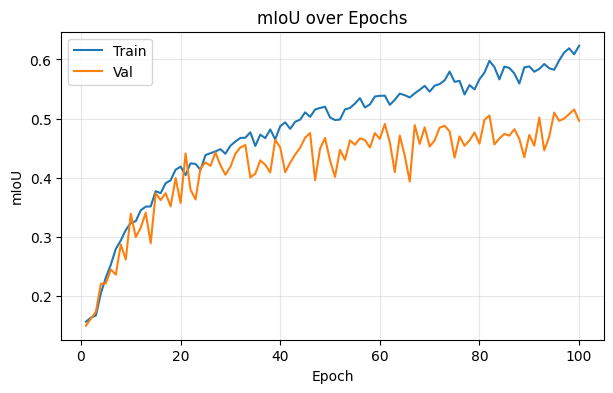

In [ ]:
plot_metric(epochs, history["train_miou"], history["val_miou"],
            title="mIoU over Epochs", ylabel="mIoU",
            save_path="/content/plot_mIoU.png")



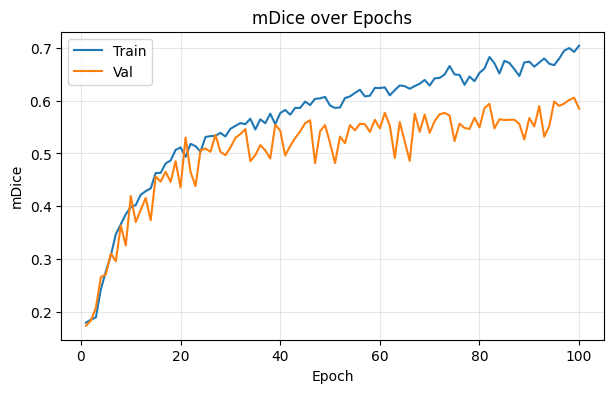

In [ ]:
plot_metric(epochs, history["train_mdice"], history["val_mdice"],
            title="mDice over Epochs", ylabel="mDice",
            save_path="/content/plot_mDice.png")